# AOS_singleAmpMag

#  Difference in star magnitude for overlapping stars on a single Amplifier

### Motivation 

A notebook to test the performance of comcam close loop (estimation of Zernike polynomials from the Wavefront Estimation Calculation pipeline) as the simulated stars are kept close (perhaps overlapping), keeping the magnitude of primary fixed, and varying the magnitude of the secondary. Thus we explore the effect of the magnitude difference between two nearby (overlapping) stars, $\Delta m$

### Performance Metric 

The RMS value between OPD results and the Zernike polynomials given by ts_wep output.

### Test Data 

Created on UW *epyc*, in `epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/`. 

The exact steps:

    cd /epyc/users/suberlak/Commissioning/aos/
    source setup_aos_2020_15.sh 
    cd  ts_phosim/notebooks/analysis_scripts/
    python runSingleAmpStarMag.py


In [6]:
#Note: can display all arguments, and even run from the ipython notebook,.
#but I find that then not all the console output gets printed here 
# - could be run as a subprocess, but then the output gets stored in wrong ISO format...
# 
!python ../analysis_scripts/runSingleAmpStarMag.py -h

usage: runSingleAmpStarMag.py [-h] [--testLabel TESTLABEL]
                              [--magPrimary MAGPRIMARY] [--starSep STARSEP]
                              [--numPro NUMPRO] [--iterNum ITERNUM]
                              [--numFields NUMFIELDS] [--numStars NUMSTARS]
                              [--opd] [--flats] [--defocalImg]
                              [--doDeblending] [--postageImg]
                              [--topDir TOPDIR] [--expDir EXPDIR]
                              [--copyDir COPYDIR]

Run ComCam AOS closed loop for varying star magnitude at fixed separation

optional arguments:
  -h, --help            show this help message and exit
  --testLabel TESTLABEL
                        test label
  --magPrimary MAGPRIMARY
                        magnitude for the primary (fixed)
  --starSep STARSEP     star separation, in percentage of ra span of the
                        amplifier - for the default 5 %, the donuts overlap.
  --numPro NUMPRO       number of p

## Results

In [1]:
import os
from astropy.table import Table
import numpy as np

# IMPORT CUSTOM FUNCTIONS 
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics
import analysisTools as at 

# IMPORT LSST MODULES 
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.Utility import getAoclcOutputPath, getConfigDir

# IMPORT PLOTTING MODULES
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [4]:
# setup the location of analysis files ... 
baseDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_after_centroid_update'
resDir = 'singleAmpMagNew'


Illustrate what we are doing (running the AOS loop 10 times, each time simulating two stars per CCD, with 9 ComCam CCDs) by plotting full image of several CCDs : 

In [5]:
#get the freshest version
import imp
imp.reload(at)

<module 'analysisTools' from '../analysis_tools/analysisTools.py'>

In [6]:
mag=16
data_dir = os.path.join(baseDir, topDir,resDir, 'mag_%d' % mag)
image = at.readPostISRImage(data_dir, focalType = 'extra', raft = 'R22', detector = 'S00',)



Reading data from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpMagNew/mag_16
For sensor R22_S00 
Done



In [8]:
centroid, centFlag = at.readCentroidInfo(data_dir, focalType='extra', raft='R22',detector='S00',
                                        obsId=9006001)

Reading centroid files from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpMagNew/mag_16/iter0/img/extra
Using  centroid_lsst_e_9006001_f1_R22_S00_E000.txt


Reading info about postage-stamp images from postagedonutStarsExtraIntra.txt


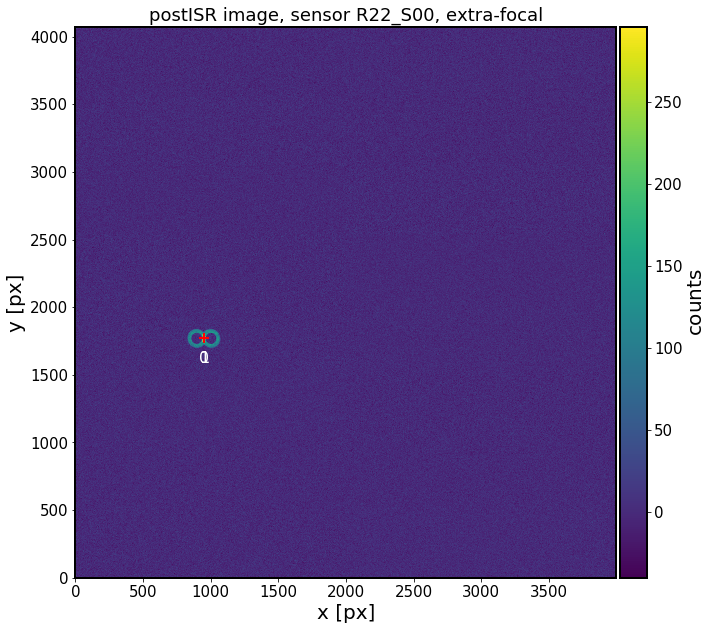

In [9]:
%matplotlib inline
postage, postFlag =  at.readPostageStars(data_dir)
at.plotImage(image,ax=None, log=False, sensor='R22_S00', focalType='extra',
          postage=postage,postFlag=postFlag, centroid=centFlag, 
          starMarker='redCross',starMarkerArgs=None,
          centMarkerArgs = None,centMarker='redCross')

Plot rms difference: 

In [19]:

ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

calcMagMetrics = calcMetrics()


magArr = [16,15]#15,14,13,12,11,10]

N = len(magArr)
colors = (np.arange(N+1)/N) 
cmap = cm.get_cmap('viridis') 

testLabel='mag'

for mag in magArr :
    testName  = '%s.%d' % (testLabel, mag)
    data_dir = os.path.join(baseDir, topDir,resDir, 'mag_%d' % mag)
    opdZkFilePath = os.path.join(data_dir,  'iter0/img/', 'opd.zer.'+ testName)
    wfsZkFilePath = os.path.join(data_dir,  'iter0/img/', 'wfs.zer.'+ testName)
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData
    wfsData = wfsData
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    
    
    # calculate sum of squared residuals : 
    # zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
    # zerTotalSSR = np.sum(zerFieldSSR)
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))


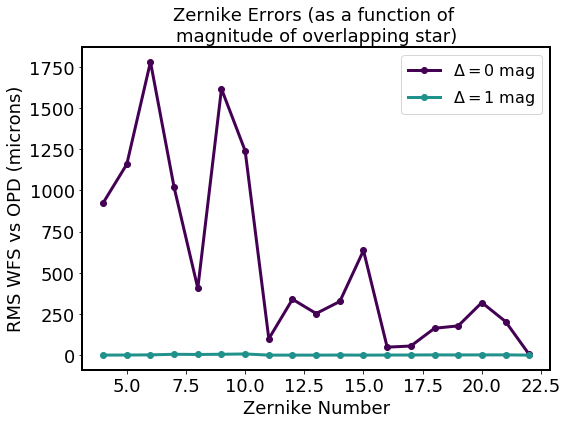

In [20]:
magPrimary = 16 

fig = plt.figure(figsize=(8,6))

for i in range(len(magArr)):
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label=r'$\Delta =%d$ mag ' % (magPrimary-magArr[i]),color = cmap(colors[i]) )
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors (as a function of \nmagnitude of overlapping star)', size=18)
    
plt.tight_layout()
# plt.savefig('StarSep_singleAmp_sep5perc_varyMag_rms_wfs_vs_opd_1.png', bbox_inches='tight', 
#            dpi=100)

In [46]:
# Read each figure as a postage stamp, store data to an array 
images = {}
for mag in magArr:
    data_dir = os.path.join(baseDir, topDir,resDir, 'mag_%d' % mag)
    images[mag] = at.readPostISRImage(data_dir, focalType = 'extra', obsId=None, raft = 'R22',
                     detector = 'S00', detNum = None, verbose=True)
    


Reading data from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_after_centroid_update/singleAmpMagNew/mag_16
For sensor R22_S00 
Done



In [ ]:
XXX go through plotZernikesAndCCD() and plotPostageStamps() : can I make them sort of switch :
        
plotPostageStamps :    
        testLabel = 'sep':
            suptitle = '%s %s-focal, sep=%.1f donut radii'%(sensor,focalType,sepInRadii)
        testLabel = 'mag'
        testLabel = 'gaia'

In [ ]:
%matplotlib inline
sepInPerc=10; testLabel='mag'; xlims=[1525,2025] ;  ylims=[750,1250]
sensor = 'R22_S00'; savefig=True
        
xmin,xmax = xlims[0], xlims[1]
ymin,ymax = ylims[0], ylims[1]

fig, ax = plt.subplots(1,2,figsize=(16,6))

if testLabel is 'sep':
    sepInRadii = sepInPercToRadii(sepInPerc)
    
    
if np.shape(rmsErrors)[0] == 19 : 
    ax[0].plot(np.arange(19)+4, rmsErrors, 
     '-o', lw=3, )# color = cmap(colors[i]))
else:
    print('Need the Zernike rms errors to be an array with 19 elements')

ax[0].set_xlabel('Zernike Number', size=18)
ax[0].set_ylabel('RMS WFS vs OPD (microns)', size=18)
if testLabel is 'sep':
    ax[0].set_title('%s, Star Sep = %.1f radii' % (sensor,sepInRadii), 
                    size=18)
if testLabel is 'mag':
    ax[0].set_title('%s, Star '%sensor+ r'$\Delta =%d$ mag' % (magPrimary-magArr[i]), 
                    size=18)
    # plot the postage stamp
    img = ax[1].imshow(np.log10(image[ymin:ymax, xmin:xmax]), vmin = 0.01,
                       cmap=cm.get_cmap('Greys'),
              origin='lower')
    #cbar= colorbar(mappable=img)
    #cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
    ax[1].set_xlabel('x [px]')
    ax[1].set_ylabel('y [px]')
    ax[1].set_title('postISR image')
    plt.tight_layout()
    if savefig:
        plt.savefig('img_AOS_singleAmpSep_postIsr_sep%d.png'%sepInPerc,
                bbox_inches='tight', dpi=150)

In [ ]:
# print Zernikes and image data 

#  plot the Zernikes 
for mag in magArr:
    
    rmsErrors = np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i])
    image = images[mag]
    
    at.plotZernikesAndCCD(image, rmsErrors, sepInPerc , xlims=[1525,2025], ylims=[750,1250],
                      sensor = 'R22_S00')


In [ ]:
# Plot the postage stamp images ...
%matplotlib inline
sensor='R22_S02'; focalType='extra';
for mag in magArr: 
    data_dir = os.path.join(baseDir, topDir,resDir, 'mag_%d' % mag)
    at.plotPostageStamps(data_dir, sensor=sensor, focalType=focalType, Nstars=2,
                         sepInPerc=sep)
